In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install open3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 91.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.6 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


<ipython-input-4-5204586b8f36>:99: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, frames=None, interval=200)  # Interval in milliseconds
/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


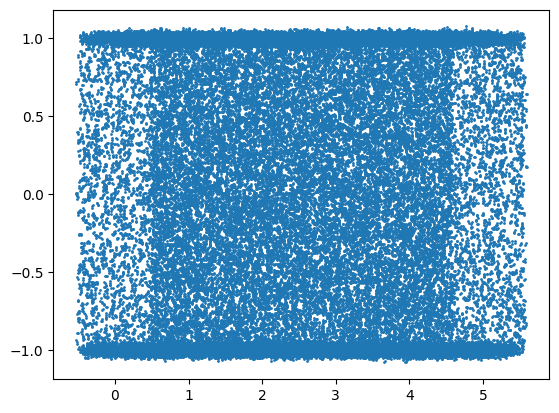

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
import open3d as o3d
import numpy as np
import os
from google.colab import files
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Function to load point clouds from files
def load_point_clouds(directory, num_scans):
    pcd_list = []
    for i in range(num_scans):
        file_path = os.path.join(directory, f"scan_{i}.txt")
        points = np.loadtxt(file_path)
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)
        pcd_list.append(pcd)
    return pcd_list

# Function to preprocess point clouds (downsample and remove outliers)
def preprocess_point_cloud(pcd, voxel_size=0.001, nb_neighbors=20, std_ratio=2.0):
    # Voxel downsampling
    pcd_down = pcd.voxel_down_sample(voxel_size)

    # Statistical outlier removal
    cl, ind = pcd_down.remove_statistical_outlier(nb_neighbors=nb_neighbors, std_ratio=std_ratio)
    pcd_clean = pcd_down.select_by_index(ind)

    return pcd_clean

# Function to register point clouds using ICP
def register_point_clouds(source, target, threshold=0.02):
    trans_init = np.identity(4)
    reg_p2p = o3d.pipelines.registration.registration_icp(
        source, target, threshold, trans_init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=2000)
    )
    return reg_p2p.transformation

# Function to merge multiple point clouds into one
def merge_point_clouds(pcd_list):
    reference_pcd = pcd_list[0]
    for pcd in pcd_list[1:]:
        transformation = register_point_clouds(pcd, reference_pcd)
        pcd.transform(transformation)
        reference_pcd += pcd
    return reference_pcd

# Function to ensure wall thickness is within tolerance
def enforce_wall_thickness(pcd, max_thickness=0.02):
    distances = np.asarray(pcd.compute_nearest_neighbor_distance())
    valid_indices = np.where(distances <= max_thickness)[0]
    pcd_thinned = pcd.select_by_index(valid_indices)
    return pcd_thinned

# Directory containing point cloud files
input_dir = r'/content/drive/My Drive/Colab Notebooks/Temporary'

# Load point clouds
num_scans = 509  # Assuming there are >5000 scans
pcd_list = load_point_clouds(input_dir, num_scans)

# Preprocess point clouds
preprocessed_pcds = [preprocess_point_cloud(pcd) for pcd in pcd_list]

# Merge point clouds
merged_pcd = merge_point_clouds(preprocessed_pcds)

# Remove outliers from the merged point cloud
merged_pcd = preprocess_point_cloud(merged_pcd)

# Enforce wall thickness
merged_pcd = enforce_wall_thickness(merged_pcd)

# Extract points for visualization
points = np.asarray(merged_pcd.points)

# Initialize Matplotlib figure and axis
fig, ax = plt.subplots()
sc = ax.scatter(points[:, 0], points[:, 1], s=1)

# Update function for animation
def update(frame):
    global merged_pcd

    # Enforce wall thickness in the merged point cloud
    merged_pcd = enforce_wall_thickness(merged_pcd)

    # Extract points for visualization
    points = np.asarray(merged_pcd.points)

    ax.clear()
    sc = ax.scatter(points[:, 0], points[:, 1], s=1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Real-time Visualization of Merged Point Cloud')

# Animate the plot
ani = FuncAnimation(fig, update, frames=None, interval=200)  # Interval in milliseconds

# Show the animation
plt.show()

# Save the merged point cloud
output_file = r'/content/drive/My Drive/Colab Notebooks/Temporary/merged_point_cloud.ply'
o3d.io.write_point_cloud(output_file, merged_pcd)

# Download the point cloud for visualization
files.download(output_file)

Number of points: 93726
Resolution: 6.536935594658047e-05 mm


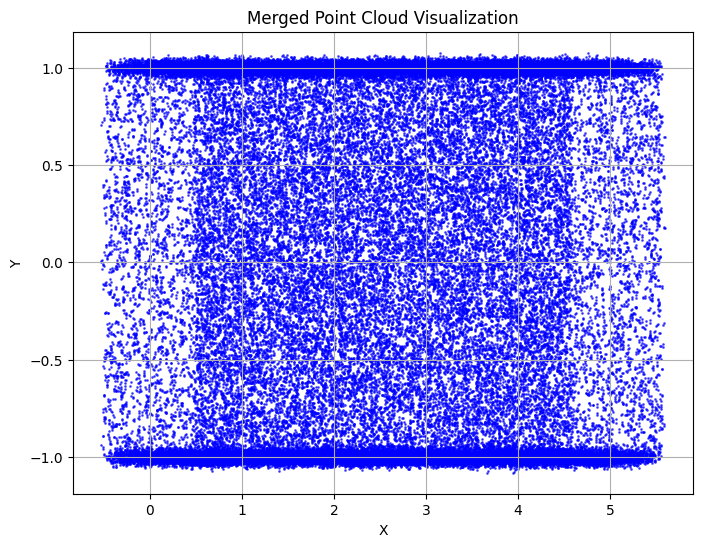

In [ ]:
import open3d as o3d
import numpy as np

# Load the merged point cloud
merged_pcd = o3d.io.read_point_cloud("merged_point_cloud.ply")

# Ensure wall thickness
distances = np.asarray(merged_pcd.compute_nearest_neighbor_distance())
max_thickness = 0.02  # 20mm tolerance
valid_indices = np.where(distances <= max_thickness)[0]
thinned_pcd = merged_pcd.select_by_index(valid_indices)

# Verify point density for resolution
points = np.asarray(thinned_pcd.points)
print("Number of points:", points.shape[0])

# Check if the point cloud meets the resolution requirement
resolution_check = (np.max(points[:, 0]) - np.min(points[:, 0])) / points.shape[0]
print("Resolution:", resolution_check, "mm")

# Visualize the result
o3d.visualization.draw_geometries([thinned_pcd])